# run a forward simulation of a UXO 
the goal here is to check that we understand the black tusk simulation, and in particular are correctly accounting for orientations of the UXO and system

In [1]:
import discretize
import numpy as np
from matplotlib import pyplot as plt
import SimPEG as simpeg
import geoana
import scipy.sparse as sp

import polarizability_model as pm
import uxo_utils

from matplotlib import rcParams
rcParams["font.size"] = 14

## Start simple: conincident loop system

In [2]:
# define system geometry -- transmitter is a horizontal square loop,
# receivers are in the centre, measure x, y, z data
rx_width=0.02
tx_width=0.05
sensorinfo = uxo_utils.CustomSensorInfo.coincident_system(
    tx_width=tx_width, rx_width=rx_width
)
ordnance = uxo_utils.load_ordnance_dict()

In [3]:
times = ordnance["4-in Sphere"]["times"]
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [4]:
n_lines = 1
line_length = 3
line_spacing = 0.5*line_length/n_lines
z_tx = 1

survey_dict = uxo_utils.create_survey(
    sensorinfo,
    times, 
    line_length=line_length,
    along_line_spacing=0.05,
    line_spacing=line_spacing,
    n_lines=n_lines,
    starting_point=np.r_[-1, 0]*line_length/2,
    z=z_tx,
    pitch=0,
    roll=0,
    yaw=0,
)

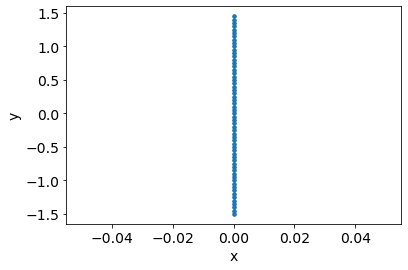

In [5]:
fig, ax = plt.subplots(1,1)

for l in np.unique(survey_dict["line"]): 
    inds = survey_dict["line"] == l
    ax.plot(
        survey_dict["pos"][inds, 0], survey_dict["pos"][inds, 1], ".", 
        color="C1" if np.all(survey_dict["yaw"][inds] > np.pi/2 ) else "C0"
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")

In [6]:
ord_key = "4-in Sphere" # "ISO Small"
ord_type = "aluminum" 

ord_inds = [i for i in range(len(ordnance[ord_key])) if ord_type in ordnance[ord_key]["common name"][i].decode("utf-8").lower()]

# ord_ind = 0  # there are multiple realizations of each in the library
ord_loc = np.r_[0, 0, 0.]
ord_ypr = np.r_[0, 0, 0]

Text(0.5, 1.0, 'Aluminum Sphere')

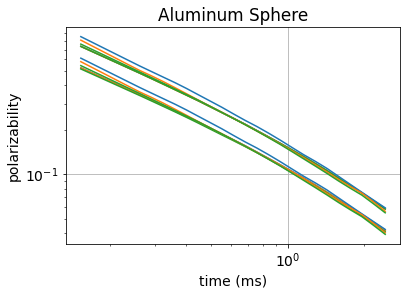

In [7]:
fig, ax = plt.subplots(1, 1)
for j in ord_inds:
    # Black Tusk likes to treat L1 as the largest, 
    # which is opposite to the ordnance dictionary
    L1, L2, L3 = (ordnance[ord_key][l][j] for l in ["L3", "L2", "L1"])
    for i, L in enumerate([L1, L2, L3]):
        ax.loglog(times, L, label=f"L{i+1}", color=f"C{i}")

ax.grid()
ax.set_xlabel("time (ms)")
ax.set_ylabel("polarizability")
ax.set_title(f"{ordnance[ord_key]['common name'][ord_inds[0]].decode('utf-8')}")
# ax.legend();

In [8]:
fwd_params = uxo_utils.create_forward_modelling_params(
    sensorinfo, 
    times, 
    mnum=survey_dict["mnum"], 
    pos=survey_dict["pos"], 
    pitch=survey_dict["pitch"], 
    roll=survey_dict["roll"], 
    yaw=survey_dict["yaw"]
)

### Compute data 

with black tusk code 

In [9]:
data_bt = {}
for i in ord_inds: 
    L1, L2, L3 = (ordnance[ord_key][l][i] for l in ["L3", "L2", "L1"])
    data_bt[i] = uxo_utils.simulate_object(
        L1, L2, L3, fwd_params, times, ord_loc, ord_ypr
    )

set up our own simulation

In [10]:
src_list = []
nrx = len(sensorinfo.receivers)
rx_area = np.max(np.abs(np.diff(sensorinfo.receivers[0].shape, axis=0)))**2

for i, txi in enumerate(survey_dict["txnum"]):
    tx = sensorinfo.transmitters[txi]
    tx_corners = tx.shape + survey_dict["xyz"][i, :]
    tx_corners = np.vstack([tx_corners, tx_corners[:1, :]])  # close the loop

    receivers = pm.MagneticFluxDensityReceiver(
        np.atleast_2d(survey_dict["xyz"][i, :]), 
        components=[rx.component for rx in sensorinfo.receivers],
        area=rx_area
    )
    src = pm.MagneticControlledSource(
        receiver_list=[receivers], location=tx_corners, current=1
    )
    src_list.append(src)

In [11]:
A = np.array([
    [np.cos(ord_ypr[0])*np.cos(ord_ypr[1])*np.cos(ord_ypr[2])-np.sin(ord_ypr[0])*np.sin(ord_ypr[2]),   np.cos(ord_ypr[0])*np.cos(ord_ypr[1])*np.sin(ord_ypr[2])+np.sin(ord_ypr[0])*np.cos(ord_ypr[2]),  -np.cos(ord_ypr[0])*np.sin(ord_ypr[1])],
    [-np.sin(ord_ypr[0])*np.cos(ord_ypr[1])*np.cos(ord_ypr[2])-np.cos(ord_ypr[0])*np.sin(ord_ypr[2]), -np.sin(ord_ypr[0])*np.cos(ord_ypr[1])*np.sin(ord_ypr[2])+np.cos(ord_ypr[0])*np.cos(ord_ypr[2]),   np.sin(ord_ypr[0])*np.sin(ord_ypr[1])],
    [np.sin(ord_ypr[1])*np.cos(ord_ypr[2]),                        np.sin(ord_ypr[1])*np.sin(ord_ypr[2]),                        np.cos(ord_ypr[1])]
])


In [12]:
def get_L_matrix(ord_ind, time_ind): 
    L1, L2, L3 = (ordnance[ord_key][l][ord_ind] for l in ["L3", "L2", "L1"])
    return np.diag([L1[time_ind], L2[time_ind], L3[time_ind]])

In [13]:
rx_shape = sensorinfo.receivers[0].shape
rx_area = (2*np.abs(rx_shape[1, 1]))**2

In [14]:
def get_G_receiver(src):
    receivers = src.receiver_list[0]  # hard coded for single 3 component receiver
    vector_distance = (
        receivers.locations[None, :, :] - np.atleast_2d(ord_loc)[:, None, :]
    )
    distance = np.linalg.norm(vector_distance, axis=2)
    rhat = vector_distance / distance[:, :, None]
    G_rx = 1 / (4*np.pi) * np.vstack([(
        1/distance[:, i]**3 * (3*np.outer(rhat[:, i, :], rhat[:, i, :]) - np.eye(3))
        ) for i in range(rhat.shape[1])
    ])
    return G_rx

In [15]:
my_data = {}

for oi in ord_inds: 
    data = np.empty((3, len(src_list), len(times)))

    polarizabilities = [A @ get_L_matrix(oi, i) @ A.T for i in range(len(times))]
    # this could be easily parallelized
    for i, src in enumerate(src_list): 
        src_field_uxo = src.eval(np.atleast_2d(ord_loc))
        G_rx = get_G_receiver(src)
        for j, P in enumerate(polarizabilities):
            moment = P @ src_field_uxo
            data[:, i, j] = G_rx @ moment * rx_area
    my_data[oi] = data

In [16]:
def plot_data_profile(data_plot, line_id=0, tind=0, ax=None, color="k"): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

    inds = survey_dict["line"].reshape(survey_dict["xyz"].shape)[:, 0] == line_id
    for i, comp in enumerate(["x", "y", "z"]):
        ax[i].plot(
            survey_dict["xyz"][inds, 1], data_plot[i, inds, tind], "-o", label=comp, 
            ms=2, color=color, alpha=1
        )
        ax[i].plot(
            survey_dict["xyz"][inds, 1], data_plot[i, inds, :], "-", label=comp, 
            color=color, alpha=0.4
        )
        ax[i].set_title(f"{comp}")
        ax[i].set_xlabel("along line (m)")

    ax[0].set_ylabel("db/dt")

    plt.tight_layout()
    return ax

array([<AxesSubplot:title={'center':'x'}, xlabel='along line (m)', ylabel='db/dt'>,
       <AxesSubplot:title={'center':'y'}, xlabel='along line (m)'>,
       <AxesSubplot:title={'center':'z'}, xlabel='along line (m)'>],
      dtype=object)

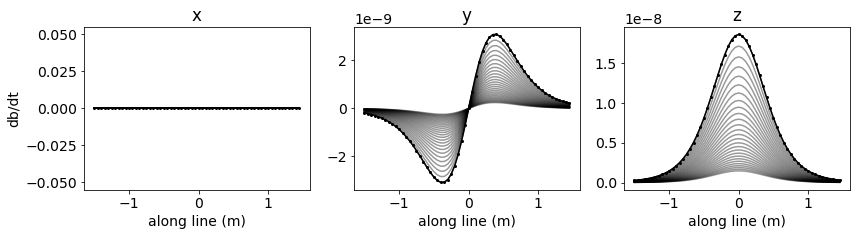

In [17]:
plot_data_profile(my_data[ord_inds[0]])

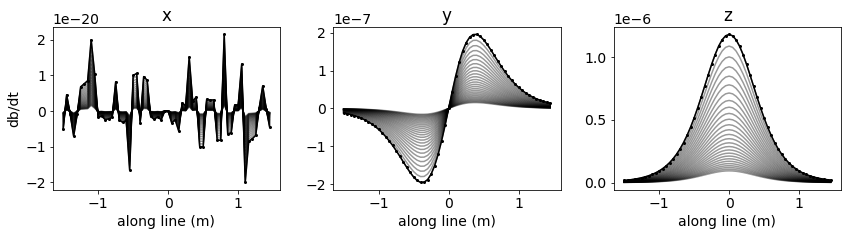

In [18]:
plot_data_profile(data_bt[ord_inds[0]]);

In [19]:
for oi in ord_inds:
    print("\n")
    for i in range(3): 
        d0 = np.max(np.abs(my_data[oi][i, :, :]))
        d1 = np.max(np.abs(data_bt[oi][i, :, :]))
        print(f"{['x', 'y', 'z'][i]}: {d0:1.3e}, {d1:1.3e}, {d1/d0:1.5e}")



x: 0.000e+00, 2.150e-20, inf
y: 3.084e-09, 1.956e-07, 6.34341e+01
z: 1.859e-08, 1.179e-06, 6.34054e+01


x: 0.000e+00, 2.500e-20, inf
y: 3.078e-09, 1.952e-07, 6.34348e+01
z: 1.928e-08, 1.222e-06, 6.34054e+01


x: 0.000e+00, 1.537e-20, inf
y: 2.151e-09, 1.364e-07, 6.34343e+01
z: 1.308e-08, 8.296e-07, 6.34054e+01


x: 0.000e+00, 1.786e-20, inf
y: 2.200e-09, 1.395e-07, 6.34348e+01
z: 1.378e-08, 8.734e-07, 6.34054e+01


/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_17666/2951672967.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  print(f"{['x', 'y', 'z'][i]}: {d0:1.3e}, {d1:1.3e}, {d1/d0:1.5e}")


/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_17666/3815905760.py:4: RuntimeWarning: divide by zero encountered in true_divide
  ax = plot_data_profile(data_bt[oi]/my_data[oi], color=f"C{ci}");
/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_17666/3815905760.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax = plot_data_profile(data_bt[oi]/my_data[oi], color=f"C{ci}");
/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_17666/3815905760.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plot_data_profile(data_bt[oi]/my_data[oi], ax=ax, color=f"C{ci}")
/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_17666/3815905760.py:6: RuntimeWarning: invalid value encountered in true_divide
  plot_data_profile(data_bt[oi]/my_data[oi], ax=ax, color=f"C{ci}")
/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_17666/3815905760.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plot_data_profile(data_bt[oi]/

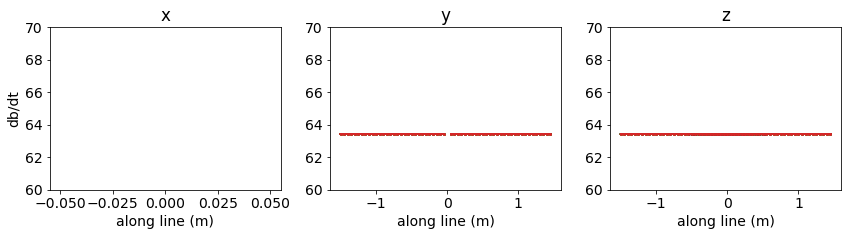

In [20]:
ax = None
for ci, oi in enumerate(ord_inds): 
    if ax is None: 
        ax = plot_data_profile(data_bt[oi]/my_data[oi], color=f"C{ci}");
    else: 
        plot_data_profile(data_bt[oi]/my_data[oi], ax=ax, color=f"C{ci}")

    for a in ax:
        a.set_ylim(60, 70)

## compare with TDEM solution from SimPEG -- single loop transmitter

In [21]:
from discretize import CylindricalMesh
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import maps
from scipy.constants import inch, mu_0
from pymatsolver import Pardiso

In [22]:
radius = 4*inch/2

sigma_air = 1e-3

sigma_steel = [5e6]
mur_steel = 150

sigma_aluminum = [1e7, 3e7, 6e7, 1e8]
mur_aluminum = 1

In [23]:
dx = 0.005
npad = 37
pf = 1.4
n_cells_per_radius = np.int64(np.ceil(radius/dx))
n_cells_vertical = np.int64(np.max([
    np.ceil(np.abs(ord_loc[2])/dx)+n_cells_per_radius, 
    np.ceil(np.abs(z_tx)/dx)
])) * 2

hx = [(dx, n_cells_per_radius + 10), (dx, npad, pf)]
hz = [(dx, npad, -pf), (dx, n_cells_vertical), (dx, npad, pf)]
mesh = CylindricalMesh([hx, [2*np.pi], hz], x0="00C")

<AxesSubplot:xlabel='x', ylabel='z'>

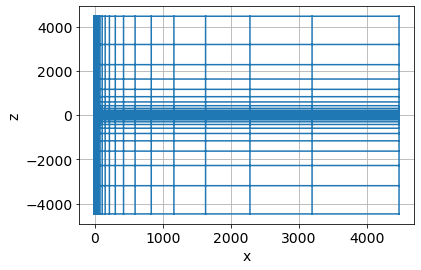

In [24]:
mesh.plot_grid()

In [25]:
ordnance[ord_key]["size mm"]

[102, 102, 102, 102, 102, 102, 102, 102]

In [26]:
inds_sphere = (mesh.cell_centers[:, 0]**2 + (mesh.cell_centers[:, 2] - ord_loc[2])**2) < radius**2

sigmas = {}

if "aluminum" in str(ordnance[ord_key]["common name"][ord_inds[0]]).lower():
    for s in sigma_aluminum:
        mur = np.ones(mesh.n_cells)
        sigma = sigma_air * np.ones(mesh.n_cells)
        sigma[inds_sphere] = s 
        sigmas[s] = sigma
elif "steel" in str(ordnance[ord_key]["common name"][ord_inds[0]]).lower():
    for s in sigma_steel:
        mur = np.ones(mesh.n_cells)
        sigma = sigma_air * np.ones(mesh.n_cells)
        sigma[inds_sphere] = s
        sigmas[s] = sigma
        mur[inds_sphere] = mur_steel

In [27]:
sigmas

{10000000.0: array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001]),
 30000000.0: array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001]),
 60000000.0: array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001]),
 100000000.0: array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001])}

In [28]:
1260*np.sqrt(times.max()*1e-3/sigma_air)

1960.0999974491099

In [29]:
for key, val in sigmas.items():
    print(val.max())

10000000.0
30000000.0
60000000.0
100000000.0


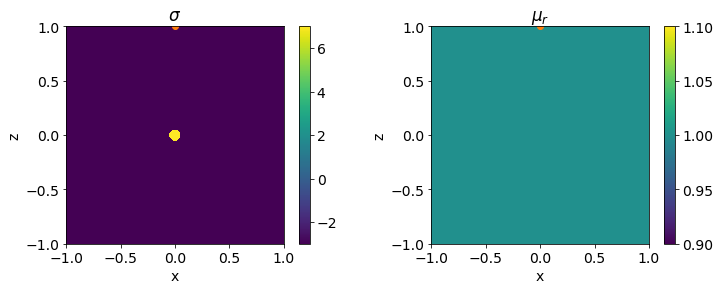

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
xlim = np.r_[-1, 1]
ylim = np.r_[-1, 1]

plt.colorbar(mesh.plot_image(np.log10(list(sigmas.values())[0]), ax=ax[0], mirror=True)[0], ax=ax[0])
ax[0].set_title("$\sigma$")

plt.colorbar(mesh.plot_image(mur, ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_title("$\mu_r$")

for a in ax:
    a.plot(np.r_[0], np.r_[z_tx], 'C1o')
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect(1)

In [31]:
receiver_list = [
    tdem.receivers.PointMagneticFieldTimeDerivative(locations=np.r_[0, 0, z_tx], orientation=comp, times=times*1e-3)  
    for comp in ["z"]
]
tx_radius = tx_width/2
simpeg_source = tdem.sources.CircularLoop(
    receiver_list=receiver_list,
    location=np.r_[0, 0, z_tx], radius=tx_radius, current=tx_width**2/(np.pi*tx_radius**2) # equivalent to a square with 1m width
) 

simpeg_survey = tdem.Survey([simpeg_source])

In [32]:
nsteps = 30
dt_list = [1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4]
time_steps = [(dt, nsteps) for dt in dt_list] 

simulation = tdem.Simulation3DElectricField(
    mesh, time_steps=time_steps, survey=simpeg_survey,
    solver=Pardiso, sigmaMap=maps.IdentityMap(mesh),
    mu=mur*mu_0
) 

/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [34]:
dpred_simpeg = {}
for key, val in sigmas.items(): 
    print(f"running {key:1.1e}")
    fields = simulation.fields(val)
    dpred_simpeg[key] = simulation.dpred(val, f=fields) * rx_width**2

/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylindricalMesh.getFaceInnerProduct has been deprecated, please use CylindricalMesh.get_face_inner_product. It will be removed in version 1.0.0 of discretize.
  warnin

running 1.0e+07


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylindricalMesh.getInterpolationMat has been deprecated, please use CylindricalMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.getInterpolationMat has been deprecated, please use TensorMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


running 3.0e+07
running 6.0e+07
running 1.0e+08


In [35]:
ind_center = int(len(survey_dict["xyz"][:, 1])/2)
survey_dict["xyz"][:, 1][ind_center]

0.0

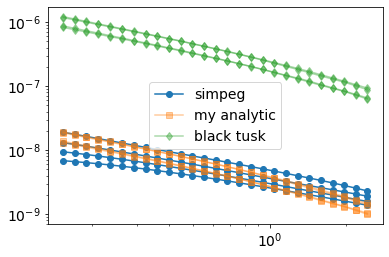

In [36]:
fig, ax = plt.subplots(1, 1)
for s, val in dpred_simpeg.items(): 
    ax.loglog(times, -val, "-o", color="C0", label="simpeg" if s == sigma_aluminum[0] else None)
    
for i, oi in enumerate(ord_inds):
    ax.loglog(times, my_data[oi][2, ind_center, :], "-s", color="C1", alpha=0.4, label="my analytic" if i == 0 else None)
    ax.loglog(times, data_bt[oi][2, ind_center, :], "-d", color="C2", alpha=0.4, label="black tusk" if i == 0 else None)
ax.legend()

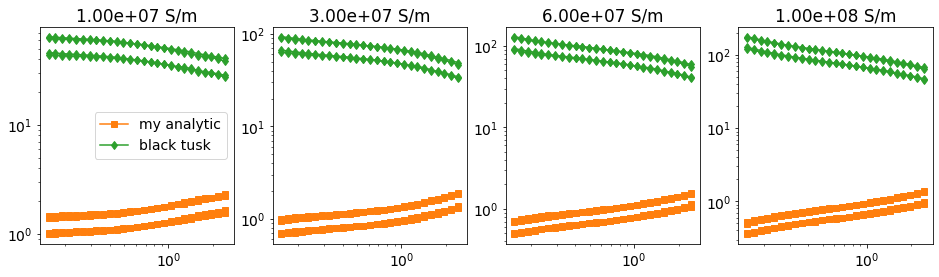

In [37]:
fig, ax = plt.subplots(1, len(sigmas.keys()), figsize=(len(sigmas.keys())*4, 4))
sigma_ind = 0
if len(sigmas.keys()) == 1:
    ax = np.r_[ax]

for si, sig in enumerate(sigmas.keys()):
    for i, oi in enumerate(ord_inds): 
        ax[si].loglog(times, 1./(my_data[oi][2, ind_center, :]/-dpred_simpeg[sig]), "C1-s", label="my analytic" if i == 0 else None)
        ax[si].loglog(times, data_bt[oi][2, ind_center, :]/-dpred_simpeg[sig], "C2-d", label="black tusk" if i == 0 else None)
    ax[si].set_title(f"{sig:1.2e} S/m")
ax[0].legend()
# ax.set_ylim([0, 5])